In [1]:
import boto3, re, sys, math, json, os, sagemaker
from sagemaker import get_execution_role
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

sys.path.append("common")
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()
s3_output_path = "s3://{}/".format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-east-2-739275482171/


In [3]:
# Define IAM role
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::739275482171:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


In [5]:
import random
from collections import defaultdict
from gym import spaces
import gym
import copy
import numpy as np

In [6]:
# Environment Setup
class DataCenterEnv(gym.Env):
    def __init__(self, compute_units=50, unit_capacities=None, task_list=None, energy_rate=0.1, temp_rate=0.05):
        super(DataCenterEnv, self).__init__()
        self.compute_units = compute_units
        self.unit_capacities = unit_capacities if unit_capacities else [1.0] * compute_units
        self.task_list = task_list if task_list else []
        self.energy_rate = energy_rate
        self.temp_rate = temp_rate
        self.total_energy_usage = 0.0
        self.total_temperature = 25.0 * compute_units
        self.rewards = []
        self.final_log = []
        self.current_task_index = 0
        self.unit_load = [[] for _ in range(compute_units)]
        self.time_remaining = [[] for _ in range(compute_units)]
        self.done = False
        self.time_steps = 0
        self.task_times = {}
        self.remaining_loads = {}
        self.previous_reward = 0.0
        self.action_counts = {i: 0 for i in range(10)}

        self.action_space = spaces.Discrete(10)
        self.observation_space = spaces.Box(
            low=0,
            high=max(self.unit_capacities),
            shape=(compute_units,),
            dtype=np.float32
        )

    def reset(self):
        self.current_task_index = 0
        self.unit_load = [[] for _ in range(self.compute_units)]
        self.time_remaining = [[] for _ in range(self.compute_units)]
        self.done = False
        self.time_steps = 0
        self.task_times = {}
        self.remaining_loads = {}
        self.total_energy_usage = 0.0
        self.total_temperature = 25.0 * self.compute_units
        self.rewards = []
        self.final_log = []
        self.previous_reward = 0.0
        self.action_counts = {i: 0 for i in range(10)}
        return np.array([sum(loads) for loads in self.unit_load], dtype=np.float32)

    def step(self, action):
        if self.done:
            raise RuntimeError("All tasks are complete, reset the environment.")

        self.action_counts[action] += 1
        self.time_steps += 1
        reward = 0

        if self.current_task_index < len(self.task_list):
            task_load, task_duration = self.task_list[self.current_task_index]

            if self.current_task_index in self.remaining_loads:
                task_load = self.remaining_loads[self.current_task_index]

            # Perform allocation based on the chosen action
            action_methods = [
                self.action_low_capacity_unit,
                self.action_low_usage_unit,
                self.action_queue_management,
                self.action_load_balancing,
                self.action_hybrid_allocation,
                self.action_batch_allocation,
                self.action_overload_redistribution,
                self.action_task_clustering,
                self.action_priority_scheduling,
                self.action_probabilistic_allocation
            ]
            remaining_load = action_methods[action](task_load, task_duration)

            if remaining_load > 0:
                self.remaining_loads[self.current_task_index] = remaining_load
            else:
                if self.current_task_index in self.remaining_loads:
                    del self.remaining_loads[self.current_task_index]

                final_usage = [round(sum(self.unit_load[i]), 2) for i in range(self.compute_units)]
                self.task_times[self.current_task_index] = {
                    "end_time": self.time_steps,
                    "final_usage": final_usage,
                    "method_id": action + 1
                }

                reward = self.calculate_reward({
                    "server_utilization": final_usage,
                    "energy_consumption": (self.total_energy_usage * 0.3, self.total_energy_usage * 0.7),
                    "temperature": self.total_temperature / self.compute_units,
                    "task_queue": len(self.task_list) - self.current_task_index
                })

                self.rewards.append(reward)
                task_log = {
                    'stat': {
                        'server_utilization': final_usage,
                        'temperature': self.total_temperature / self.compute_units,
                        'task_queue': len(self.task_list) - self.current_task_index
                    },
                    'choice': action + 1,
                    'reward': reward
                }
                self.final_log.append(task_log)
                self.current_task_index += 1

        # Update compute units and energy usage
        for i in range(self.compute_units):
            for j in range(len(self.unit_load[i]) - 1, -1, -1):
                load = self.unit_load[i][j]
                duration = self.time_remaining[i][j]
                self.total_energy_usage += load * duration * self.energy_rate * self.unit_capacities[i]
                self.total_temperature += load / self.unit_capacities[i] * duration * self.temp_rate
                self.time_remaining[i][j] -= 1

                if self.time_remaining[i][j] <= 0:
                    self.unit_load[i].pop(j)
                    self.time_remaining[i].pop(j)

        if self.current_task_index >= len(self.task_list):
            self.done = True

        if self.time_steps >= 10000:
            self.done = True

        smoothed_reward = 0.9 * self.previous_reward + 0.1 * reward
        self.previous_reward = smoothed_reward
        return np.array([sum(loads) for loads in self.unit_load], dtype=np.float32), smoothed_reward, self.done, {"task_times": self.task_times}

    def calculate_reward(self, state):
        reward = 0.0
        utilization = np.mean(state["server_utilization"])
        target_utilization = 0.725
        reward += 10 * np.exp(-abs(utilization - target_utilization))

        renewable, non_renewable = state["energy_consumption"]
        energy_efficiency = renewable / (renewable + non_renewable + 1e-5)
        reward += 15 * energy_efficiency

        temperature = state["temperature"]
        ideal_temp = 75
        reward += max(0, 5 - np.tanh((temperature - ideal_temp) / 10))

        task_queue = state["task_queue"]
        reward += 10 / (1 + task_queue)

        random_incentive = np.random.uniform(0, 1)
        reward += random_incentive * 2

        return reward

    def solve_unallocated_tasks(self):
        for task_index, remaining_load in list(self.remaining_loads.items()):
            if task_index >= len(self.task_list):
                print(f"Invalid task index {task_index} found in remaining_loads. Skipping...")
                del self.remaining_loads[task_index]
                continue

            for unit_index in range(self.compute_units):
                available_capacity = self.unit_capacities[unit_index] - sum(self.unit_load[unit_index])

                if available_capacity > 0:
                    assigned_load = min(remaining_load, available_capacity)
                    self.unit_load[unit_index].append(assigned_load)
                    self.time_remaining[unit_index].append(self.task_list[task_index][1])
                    remaining_load -= assigned_load

                    if remaining_load <= 0:
                        del self.remaining_loads[task_index]
                        break

            if remaining_load <= 0:
                final_usage = [round(sum(self.unit_load[i]), 2) for i in range(self.compute_units)]
                reward = self.calculate_reward({
                    "server_utilization": final_usage,
                    "energy_consumption": (self.total_energy_usage * 0.3, self.total_energy_usage * 0.7),
                    "temperature": self.total_temperature / self.compute_units,
                    "task_queue": len(self.remaining_loads)
                })

                self.rewards.append(reward)
                task_log = {
                    'stat': {
                        'server_utilization': final_usage,
                        'temperature': self.total_temperature / self.compute_units,
                        'task_queue': len(self.remaining_loads)
                    },
                    'choice': "Unallocated task resolved",
                    'reward': reward
                }
                self.final_log.append(task_log)

        print(f"Unallocated task loads solved. Remaining unallocated tasks: {len(self.remaining_loads)}")

    def action_low_capacity_unit(self, task_load, task_duration):
        min_capacity_unit = min(range(self.compute_units), key=lambda i: self.unit_capacities[i])
        available_capacity = self.unit_capacities[min_capacity_unit] - sum(self.unit_load[min_capacity_unit])
        assigned_load = min(task_load, available_capacity)
        self.unit_load[min_capacity_unit].append(assigned_load)
        self.time_remaining[min_capacity_unit].append(task_duration)
        return task_load - assigned_load

    def action_low_usage_unit(self, task_load, task_duration):
        min_usage_unit = min(range(self.compute_units), key=lambda i: sum(self.unit_load[i]) / self.unit_capacities[i])
        available_capacity = self.unit_capacities[min_usage_unit] - sum(self.unit_load[min_usage_unit])
        assigned_load = min(task_load, available_capacity)
        self.unit_load[min_usage_unit].append(assigned_load)
        self.time_remaining[min_usage_unit].append(task_duration)
        return task_load - assigned_load

    def action_queue_management(self, task_load, task_duration):
        num_units_to_use = min(5, self.compute_units)
        small_task_load = task_load / num_units_to_use
        for i in range(num_units_to_use):
            available_capacity = self.unit_capacities[i] - sum(self.unit_load[i])
            assigned_load = min(small_task_load, available_capacity)
            self.unit_load[i].append(assigned_load)
            self.time_remaining[i].append(task_duration)
        return 0

    def action_load_balancing(self, task_load, task_duration):
        avg_load = task_load / self.compute_units
        for i in range(self.compute_units):
            available_capacity = self.unit_capacities[i] - sum(self.unit_load[i])
            assigned_load = min(avg_load, available_capacity)
            self.unit_load[i].append(assigned_load)
            self.time_remaining[i].append(task_duration)
        return 0

    def action_hybrid_allocation(self, task_load, task_duration):
        scores = [
            (1 / (1 + sum(self.unit_load[i]))) * 0.4 +
            (1 / (1 + self.total_temperature / self.compute_units)) * 0.3 +
            (1 / (self.unit_capacities[i] * self.energy_rate)) * 0.3
            for i in range(self.compute_units)
        ]
        selected_unit = np.argmax(scores)
        available_capacity = self.unit_capacities[selected_unit] - sum(self.unit_load[selected_unit])
        assigned_load = min(task_load, available_capacity)
        self.unit_load[selected_unit].append(assigned_load)
        self.time_remaining[selected_unit].append(task_duration)
        return task_load - assigned_load

    def action_batch_allocation(self, task_load, task_duration):
        batch_size = 5
        batch_tasks = self.task_list[self.current_task_index:self.current_task_index + batch_size]
        for task in batch_tasks:
            load, duration = task
            for i in range(self.compute_units):
                available_capacity = self.unit_capacities[i] - sum(self.unit_load[i])
                if load <= available_capacity:
                    self.unit_load[i].append(load)
                    self.time_remaining[i].append(duration)
                    load = 0
                    break
                else:
                    load -= available_capacity
                    self.unit_load[i].append(available_capacity)
                    self.time_remaining[i].append(duration)
        self.current_task_index += batch_size
        return task_load

    def action_overload_redistribution(self, task_load, task_duration):
        overloaded_units = [
            i for i in range(self.compute_units)
            if sum(self.unit_load[i]) > self.unit_capacities[i] * 0.9
        ]
        underutilized_units = [
            i for i in range(self.compute_units)
            if sum(self.unit_load[i]) < self.unit_capacities[i] * 0.5
        ]

        for overloaded_unit in overloaded_units:
            excess_load = sum(self.unit_load[overloaded_unit]) - self.unit_capacities[overloaded_unit]
            for underutilized_unit in underutilized_units:
                available_capacity = self.unit_capacities[underutilized_unit] - sum(self.unit_load[underutilized_unit])
                transferred_load = min(excess_load, available_capacity)

                self.unit_load[underutilized_unit].append(transferred_load)
                self.time_remaining[underutilized_unit].append(task_duration)

                for idx, load in enumerate(self.unit_load[overloaded_unit]):
                    if load >= transferred_load:
                        self.unit_load[overloaded_unit][idx] -= transferred_load
                        if self.unit_load[overloaded_unit][idx] == 0:
                            self.unit_load[overloaded_unit].pop(idx)
                            self.time_remaining[overloaded_unit].pop(idx)
                        break

                excess_load -= transferred_load
                if excess_load <= 0:
                    break

        return task_load

    def action_task_clustering(self, task_load, task_duration):
        duration_thresholds = [2, 5, 10]
        clusters = {threshold: [] for threshold in duration_thresholds}
        for task in self.task_list[self.current_task_index:]:
            load, duration = task
            for threshold in duration_thresholds:
                if duration <= threshold:
                    clusters[threshold].append(task)
                    break
        for threshold, tasks in clusters.items():
            for task in tasks:
                load, duration = task
                for i in range(self.compute_units):
                    available_capacity = self.unit_capacities[i] - sum(self.unit_load[i])
                    assigned_load = min(load, available_capacity)
                    self.unit_load[i].append(assigned_load)
                    self.time_remaining[i].append(duration)
                    load -= assigned_load
                    if load <= 0:
                        break
        return 0

    def action_priority_scheduling(self, task_load, task_duration):
        prioritized_tasks = sorted(
            self.task_list[self.current_task_index:],
            key=lambda task: task[0] * 0.7 + task[1] * 0.3,
            reverse=True
        )
        for task in prioritized_tasks:
            load, duration = task
            for i in range(self.compute_units):
                available_capacity = self.unit_capacities[i] - sum(self.unit_load[i])
                assigned_load = min(load, available_capacity)
                self.unit_load[i].append(assigned_load)
                self.time_remaining[i].append(duration)
                load -= assigned_load
                if load <= 0:
                    break
        return 0

    def action_probabilistic_allocation(self, task_load, task_duration):
        weights = np.array([
            max(0, self.unit_capacities[i] * 0.4) +
            max(0, (1 / (1 + sum(self.unit_load[i]))) * 0.3) +
            max(0, (1 / (self.total_temperature / self.compute_units)) * 0.3)
            for i in range(self.compute_units)
        ])

        total_weight = np.sum(weights)
        if total_weight == 0:
            weights = np.ones(self.compute_units)
            total_weight = np.sum(weights)

        probabilities = weights / total_weight

        selected_unit = np.random.choice(range(self.compute_units), p=probabilities)
        available_capacity = self.unit_capacities[selected_unit] - sum(self.unit_load[selected_unit])
        assigned_load = min(task_load, available_capacity)
        self.unit_load[selected_unit].append(assigned_load)
        self.time_remaining[selected_unit].append(task_duration)
        return task_load - assigned_load

    def render(self, mode="human"):
        avg_energy_usage = self.total_energy_usage / self.compute_units
        avg_temperature = self.total_temperature / self.compute_units
        print(f"Unit loads: {[sum(loads) for loads in self.unit_load]}")
        print(f"Remaining tasks: {len(self.task_list) - self.current_task_index}")
        print(f"Average energy usage: {avg_energy_usage}")
        print(f"Average temperature: {avg_temperature}")
        if self.rewards:
            print(f"Last task reward: {self.rewards[-1]}")
            print("Log:", self.final_log[-1])
            
    def clone(self):
        """
        Creates a deep copy of the current environment instance.
        This ensures that a new environment is created with the same state as the current one.
        """
        new_env = copy.deepcopy(self)

        return new_env

# Generate realistic task list
task_list = [(random.uniform(1.0, 10.0), random.randint(1, 10)) for _ in range(500)]
unit_capacities = [random.choice([1.6, 3.2, 6.4]) for _ in range(50)]

# Initialize and test the environment
env = DataCenterEnv(compute_units=50, unit_capacities=unit_capacities, task_list=task_list)
obs = env.reset()
done = False
q = 0
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.solve_unallocated_tasks()
    # print(q)
    # q += 1

# Display final results
print("Average energy usage:", env.total_energy_usage / env.compute_units)
print("Average temperature:", env.total_temperature / env.compute_units)
print("Total tasks completed:", len(env.final_log))
print("Rewards:", env.rewards)
print("Action counts:", env.action_counts)

Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 1
Unallocated task loads solved. Remaining unallocated tasks: 2
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unallocated task loads solved. Remaining unallocated tasks: 0
Unalloca

In [ ]:
# Running a baseline value
def run_baseline(env):
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = env.action_space.sample()  
        obs, reward, done, _ = env.step(action)
        total_reward += reward
    return env.total_energy_usage, total_reward, env.time_steps,env.action_counts,(env.total_temperature / env.compute_units)

baseline_energy, baseline_reward, baseline_steps,baseline_action_counts,baseline_temperature = run_baseline(env)
print(f"Random BaseLine Model Total Energy Usage: {baseline_energy}")
print(f"Random BaseLine Model Total Reward: {baseline_reward}")
print(f"Random BaseLine Model Total Time Steps: {baseline_steps}")
print(f"Random BaseLine Model Action Counts: {baseline_action_counts}")
print(f"Random BaseLine Model Average Temperature: {baseline_temperature}")

Random BaseLine Model Total Energy Usage: 115360.83233540559
Random BaseLine Model Total Reward: 2976.7428346369747
Random BaseLine Model Total Time Steps: 490
Random BaseLine Model Action Counts: {0: 55, 1: 58, 2: 44, 3: 49, 4: 39, 5: 56, 6: 49, 7: 52, 8: 42, 9: 46}
Random BaseLine Model Average Temperature: 89.3578397769234


In [11]:
# Defining PPO 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

class PPOActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(PPOActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        policy = self.actor(x)
        value = self.critic(x)
        return policy, value

# PPO Agent with training logic
class PPOAgent:
    def __init__(self, env, actor_critic, lr=3e-4, gamma=0.95, epsilon=0.1):
        self.env = env
        self.actor_critic = actor_critic
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.log_probs = []
        self.values = []
        self.rewards = []

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        policy, value = self.actor_critic(state)
        dist = Categorical(policy)
        action = dist.sample()
        self.log_probs.append(dist.log_prob(action))
        self.values.append(value)
        return action.item()

    def calculate_returns(self, next_value):
        returns = []
        R = next_value
        for reward in reversed(self.rewards):
            R = reward + self.gamma * R
            returns.insert(0, R)
        return returns

    def update_policy(self):
        # Calculate returns
        next_value = self.values[-1].detach()  # Use the last value estimate
        returns = self.calculate_returns(next_value)
        returns = torch.tensor(returns, dtype=torch.float32)

        log_probs = torch.stack(self.log_probs)
        values = torch.stack(self.values).squeeze()
        advantages = returns - values

        # Actor loss (policy gradient with PPO clipping)
        ratio = torch.exp(log_probs - log_probs.detach())
        actor_loss = torch.mean(torch.min(
            ratio * advantages,
            torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages
        ))

        # Critic loss (value function approximation)
        critic_loss = nn.MSELoss()(values, returns)

        # Total loss and optimization step
        loss = -actor_loss + 0.5 * critic_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Clear memory
        self.log_probs = []
        self.values = []
        self.rewards = []

    def train(self, num_episodes):
        reward_history = []
        average_temperature_history = []
        action_counts_history = []
        time_steps_history = []
        energy_usage_history = []
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0  # reward for each episode

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.rewards.append(reward)
                episode_reward += reward  # cumulative reward
                state = next_state
                

            # record the history for each episode
            reward_history.append(episode_reward)
            average_temperature_history.append(env.total_temperature / env.compute_units)
            action_counts_history.append(env.action_counts)
            time_steps_history.append(env.time_steps)
            energy_usage_history.append(env.total_energy_usage)
            
            # Update policy at the end of every 10 episodes
            # if (episode + 1) % 5 == 0: 
            self.update_policy()

            # Print the total reward every 20 episode 
            if (episode + 1) % 20 == 0:
                print(f"Episode {episode + 1}/{num_episodes} - Total Reward: {episode_reward:.2f}")
                
        return reward_history, average_temperature_history, action_counts_history, time_steps_history, energy_usage_history

# Instantiate the environment
#env = DataCenterEnv(compute_units=50, unit_capacities=unit_capacities, task_list=generate_tasks(500))

# Instantiate the PPO Agent
actor_critic_model = PPOActorCritic(env.observation_space.shape[0], env.action_space.n)
ppo_agent = PPOAgent(env, actor_critic_model)

# Train the PPO agent
PPO_reward_history, PPO_average_temperature_history, PPO_action_counts_history, PPO_time_steps_history, PPO_energy_usage_history = ppo_agent.train(num_episodes=1000)

# Evaluate the trained model
state = env.reset()
done = False
total_reward = 0
while not done:
    action = ppo_agent.select_action(state)
    state, reward, done, info = env.step(action)
    total_reward += reward

print(f"PPO Model Total Reward after Evaluation: {total_reward}")
print("PPO Model Final Action Counts:", env.action_counts)
print("PPO Model Total time steps:", env.time_steps)
print("PPO Model Total energy consumed:", env.total_energy_usage)
print("PPO Model Average temperature:", (env.total_temperature / env.compute_units))

Episode 20/1000 - Total Reward: 3040.20
Episode 40/1000 - Total Reward: 3759.17
Episode 60/1000 - Total Reward: 5375.73
Episode 80/1000 - Total Reward: 5264.30
Episode 100/1000 - Total Reward: 5294.73
Episode 120/1000 - Total Reward: 5108.72
Episode 140/1000 - Total Reward: 4759.40
Episode 160/1000 - Total Reward: 5305.16
Episode 180/1000 - Total Reward: 5431.67
Episode 200/1000 - Total Reward: 5539.29
Episode 220/1000 - Total Reward: 5968.84
Episode 240/1000 - Total Reward: 5464.75
Episode 260/1000 - Total Reward: 5902.50
Episode 280/1000 - Total Reward: 5893.43
Episode 300/1000 - Total Reward: 5952.21
Episode 320/1000 - Total Reward: 5892.38
Episode 340/1000 - Total Reward: 5835.73
Episode 360/1000 - Total Reward: 5849.66
Episode 380/1000 - Total Reward: 5969.27
Episode 400/1000 - Total Reward: 5643.28
Episode 420/1000 - Total Reward: 5686.87
Episode 440/1000 - Total Reward: 5794.63
Episode 460/1000 - Total Reward: 6038.52
Episode 480/1000 - Total Reward: 5993.28
Episode 500/1000 - T

In [26]:
PPO_reward = total_reward
PPO_energy = env.total_energy_usage
PPO_action_counts = env.action_counts
PPO_steps = env.time_steps
PPO_temperature = env.total_temperature / env.compute_units

In [12]:
# Defining the Linear Q Function

class LinearQFunction:
    def __init__(self, env, learning_rate=0.01, discount_factor=0.99, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        
        # Initialize weights for the linear model
        self.num_features = env.observation_space.shape[0] + env.action_space.n
        self.weights = np.random.randn(self.num_features)
    
    def _extract_features(self, state, action):
        """Extract feature vector for state-action pair."""
        action_one_hot = np.zeros(self.env.action_space.n)
        action_one_hot[action] = 1
        return np.concatenate([state, action_one_hot])
    
    def predict_q(self, state, action):
        """Predict Q-value for a given state and action."""
        features = self._extract_features(state, action)
        return np.dot(self.weights, features)
    
    def best_action(self, state):
        """Choose the best action based on the current Q-function."""
        q_values = [self.predict_q(state, a) for a in range(self.env.action_space.n)]
        return np.argmax(q_values)
    
    def epsilon_greedy_action(self, state):
        """Choose an action using epsilon-greedy policy."""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return self.best_action(state)
    
    def update(self, state, action, reward, next_state, done):
        """Update weights using the Q-learning update rule."""
        features = self._extract_features(state, action)
        q_current = np.dot(self.weights, features)
        
        if done:
            td_target = reward
        else:
            next_q = max(self.predict_q(next_state, a) for a in range(self.env.action_space.n))
            td_target = reward + self.gamma * next_q
        
        td_error = td_target - q_current
        self.weights += self.lr * td_error * features

# Train Linear Q-function
def train_linear_q(env, num_episodes=1000):
    agent = LinearQFunction(env)
    reward_history = []
    average_temperature_history = []
    action_counts_history = []
    time_steps_history = []
    energy_usage_history = []
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = agent.epsilon_greedy_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
        
        reward_history.append(episode_reward)
        average_temperature_history.append(env.total_temperature / env.compute_units)
        action_counts_history.append(env.action_counts)
        time_steps_history.append(env.time_steps)
        energy_usage_history.append(env.total_energy_usage)
        
        if (episode + 1) % 20 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward}")
    
    return agent, reward_history, average_temperature_history, action_counts_history, time_steps_history, energy_usage_history

# Evaluate Linear Q-function
def evaluate_linear_q(env, agent):
    state = env.reset()
    total_reward = 0
    total_energy_usage = 0
    done = False
    
    while not done:
        action = agent.best_action(state)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        #total_energy_usage = env.total_energy_usage
    
    return total_reward, env.total_energy_usage, env.time_steps, env.action_counts,(env.total_temperature / env.compute_units)

# Train and Evaluate
linear_q_agent, linear_q_rewards_history, linear_q_temperature_history, linear_q_action_counts_history, linear_q_time_steps_history, linear_q_energy_usage_history = train_linear_q(env, num_episodes=1000)

# Evaluate trained Linear Q-function
linear_q_reward, linear_q_energy, linear_q_steps, linear_q_action_counts, linear_q_temperature = evaluate_linear_q(env, linear_q_agent)
print(f"Linear Q-function Total Reward: {linear_q_reward}")
print(f"Linear Q-function Total Energy Usage: {linear_q_energy}")
print(f"Linear Q-function Total Time Steps: {linear_q_steps}")
print(f"Linear Q-function Total Action Counts: {linear_q_action_counts}")
print(f"Linear Q-function Average Temperature: {linear_q_temperature}")

Episode 20/1000, Total Reward: 203.5941683214703
Episode 40/1000, Total Reward: 4702.358788621724
Episode 60/1000, Total Reward: 7763.395092368882
Episode 80/1000, Total Reward: 8692.87484385589
Episode 100/1000, Total Reward: 7696.129832146551
Episode 120/1000, Total Reward: 6202.744227566736
Episode 140/1000, Total Reward: 8188.362205139182
Episode 160/1000, Total Reward: 4871.705794963363
Episode 180/1000, Total Reward: 46.77520873731037


/tmp/ipykernel_29365/3471931916.py:49: RuntimeWarning: invalid value encountered in multiply
  self.weights += self.lr * td_error * features


Episode 200/1000, Total Reward: 4541.798502969702
Episode 220/1000, Total Reward: 4872.891105568394
Episode 240/1000, Total Reward: 4843.830071581556
Episode 260/1000, Total Reward: 5236.871443575699
Episode 280/1000, Total Reward: 4911.610103070317
Episode 300/1000, Total Reward: 4917.364726257823
Episode 320/1000, Total Reward: 4666.049889888198
Episode 340/1000, Total Reward: 5004.705440521929
Episode 360/1000, Total Reward: 4750.637592678977
Episode 380/1000, Total Reward: 4658.757419809504
Episode 400/1000, Total Reward: 4925.090069542652
Episode 420/1000, Total Reward: 4583.454717119619
Episode 440/1000, Total Reward: 4518.894246963073
Episode 460/1000, Total Reward: 5402.32990613352
Episode 480/1000, Total Reward: 4879.927226967498
Episode 500/1000, Total Reward: 5126.703273723604
Episode 520/1000, Total Reward: 5024.254483431105
Episode 540/1000, Total Reward: 4542.825320319541
Episode 560/1000, Total Reward: 4879.368096417593
Episode 580/1000, Total Reward: 4907.238872415807
E

In [ ]:
# Result data collation
results = {
    "baseline": {
        "energy": baseline_energy,
        "reward": baseline_reward,
        "steps": baseline_steps,
        "action_counts": baseline_action_counts,
        "temperature": baseline_temperature
    },

    "linear_q": {
        "energy": linear_q_energy,
        "reward": linear_q_reward,
        "steps": linear_q_steps,
        "action_counts": linear_q_action_counts,
        "temperature": linear_q_temperature,
        "rewards_history": linear_q_rewards_history,
        "temperature_history": linear_q_temperature_history,
        "action_counts_history": linear_q_action_counts_history,
        "time_steps_history": linear_q_time_steps_history,
        "energy_usage_history": linear_q_energy_usage_history
    },
    "ppo": {
        "energy": PPO_energy,
        "reward": PPO_reward,
        "steps": PPO_steps,
        "action_counts": PPO_action_counts,
        "temperature": PPO_temperature,
        "reward_history": PPO_reward_history,
        "average_temperature_history": PPO_average_temperature_history,
        "action_counts_history": PPO_action_counts_history,
        "time_steps_history": PPO_time_steps_history,
        "energy_usage_history": PPO_energy_usage_history
    }
}

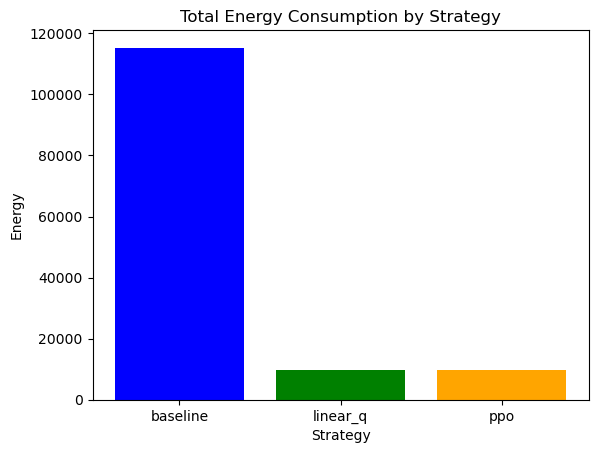

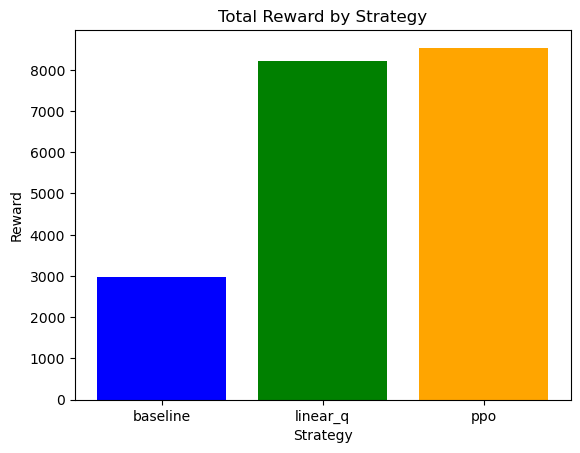

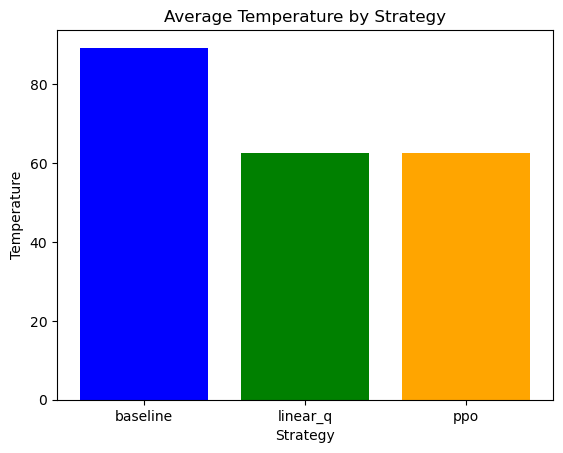

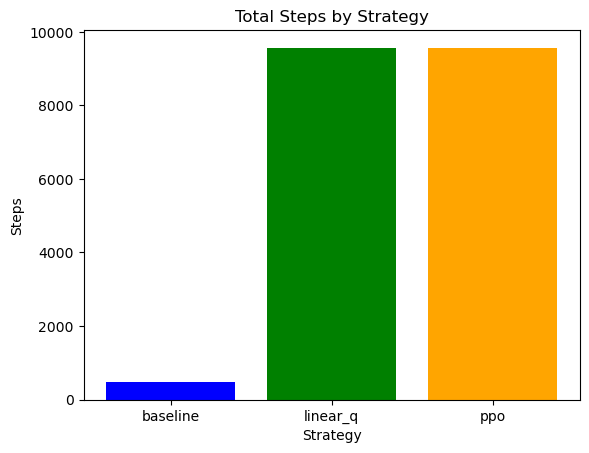

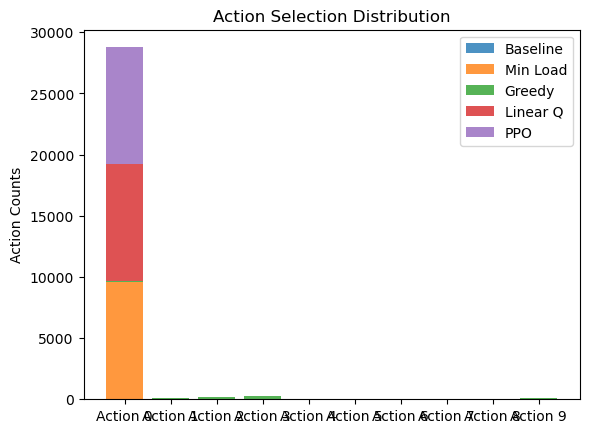

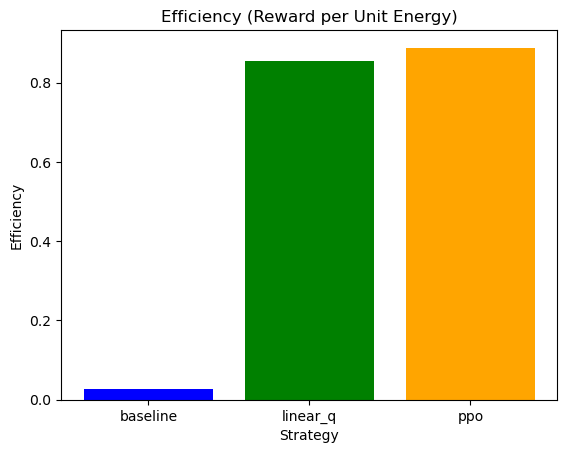

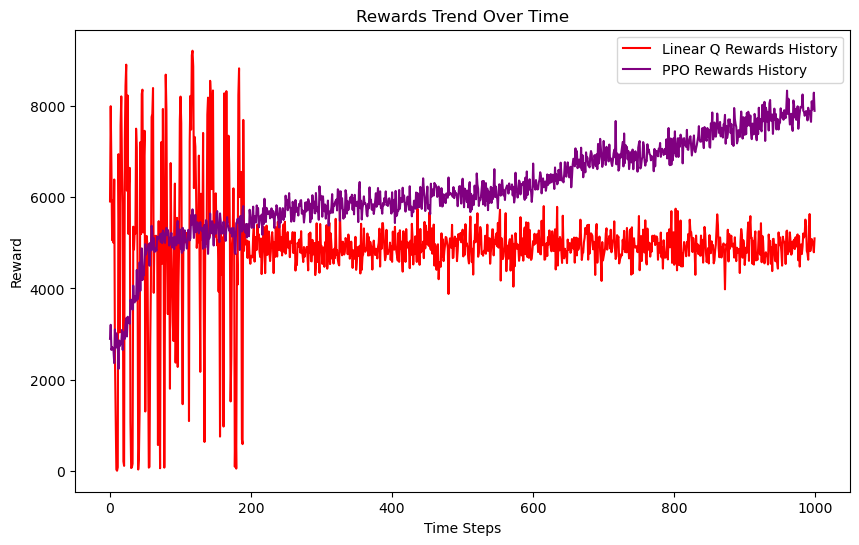

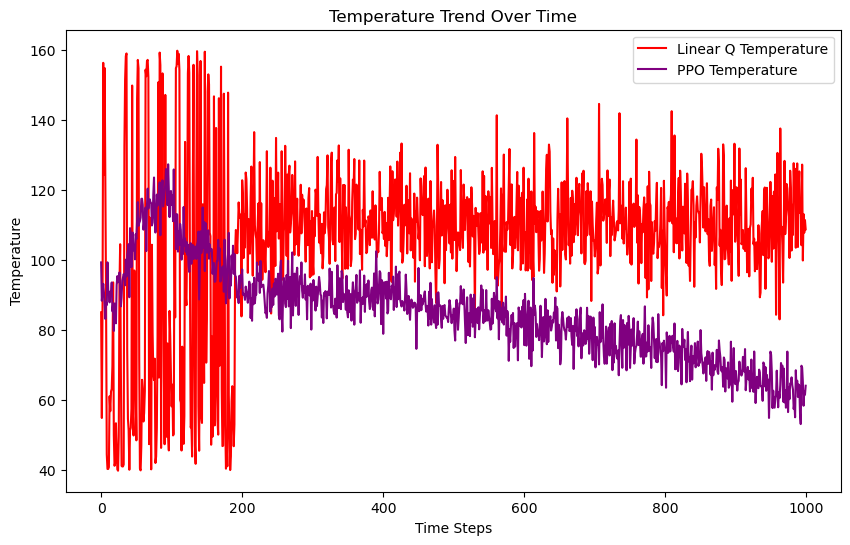

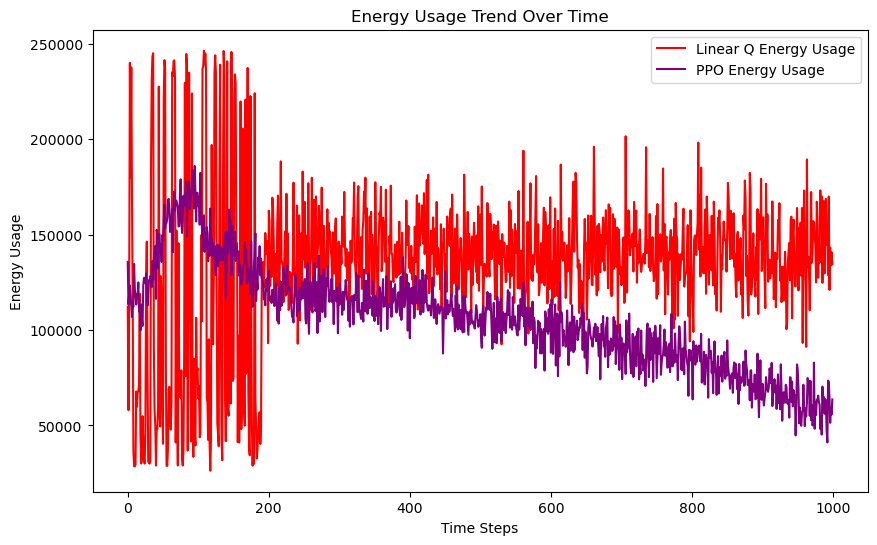

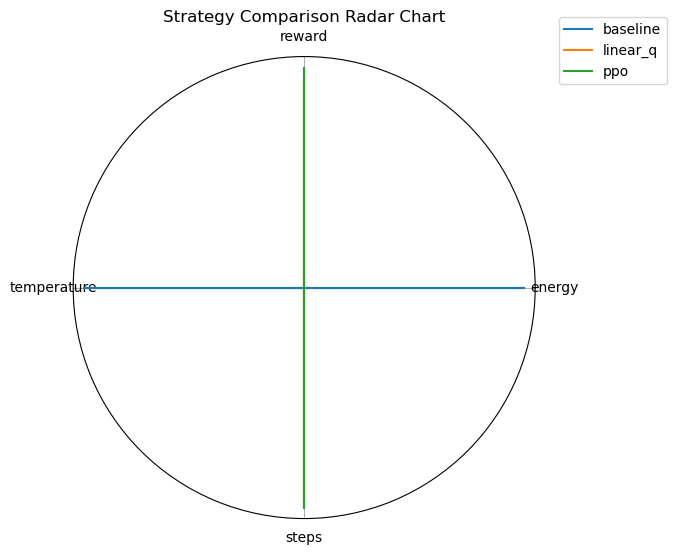

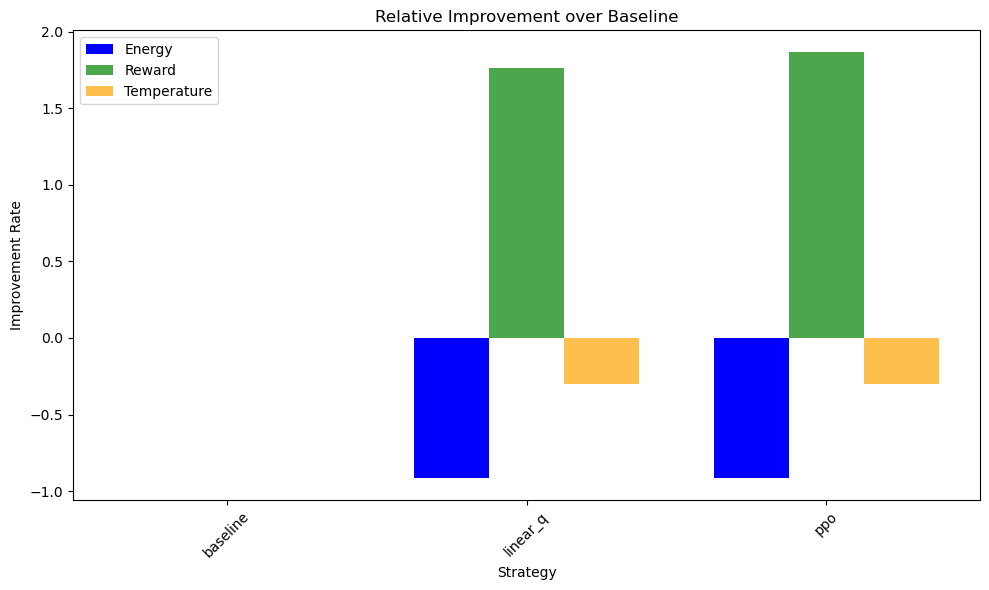

In [37]:
import matplotlib.pyplot as plt

strategies = list(results.keys())
energies = [results[s]["energy"] for s in strategies]

plt.bar(strategies, energies, color=["blue", "green", "orange", "red", "purple"])
plt.title("Total Energy Consumption by Strategy")
plt.ylabel("Energy")
plt.xlabel("Strategy")
plt.show()

# 2. Total Reward Comparison
rewards = [results[s]["reward"] for s in strategies]

plt.bar(strategies, rewards, color=["blue", "green", "orange", "red", "purple"])
plt.title("Total Reward by Strategy")
plt.ylabel("Reward")
plt.xlabel("Strategy")
plt.show()

# 3. Comparison of average temperatures
temperatures = [results[s]["temperature"] for s in strategies]

plt.bar(strategies, temperatures, color=["blue", "green", "orange", "red", "purple"])
plt.title("Average Temperature by Strategy")
plt.ylabel("Temperature")
plt.xlabel("Strategy")
plt.show()

# 4. Comparison of Time Steps
steps = [results[s]["steps"] for s in strategies]

plt.bar(strategies, steps, color=["blue", "green", "orange", "red", "purple"])
plt.title("Total Steps by Strategy")
plt.ylabel("Steps")
plt.xlabel("Strategy")
plt.show()

# 5. Comparison of action distribution
action_labels = list(range(env.action_space.n))
baseline_actions = [baseline_action_counts[a] for a in action_labels]
min_load_actions = [min_load_action_counts[a] for a in action_labels]
greedy_actions = [greedy_action_counts[a] for a in action_labels]
linear_q_actions = [linear_q_action_counts[a] for a in action_labels]
ppo_actions = [PPO_action_counts[a] for a in action_labels]

x = range(len(action_labels))
plt.bar(x, baseline_actions, label="Baseline", alpha=0.8)
plt.bar(x, min_load_actions, bottom=baseline_actions, label="Min Load", alpha=0.8)
plt.bar(x, greedy_actions, bottom=[baseline_actions[i] + min_load_actions[i] for i in x], label="Greedy", alpha=0.8)
plt.bar(x, linear_q_actions, bottom=[baseline_actions[i] + min_load_actions[i] + greedy_actions[i] for i in x], label="Linear Q", alpha=0.8)
plt.bar(x, ppo_actions, bottom=[baseline_actions[i] + min_load_actions[i] + greedy_actions[i] + linear_q_actions[i] for i in x], label="PPO", alpha=0.8,)

plt.xticks(x, [f"Action {a}" for a in action_labels])
plt.ylabel("Action Counts")
plt.title("Action Selection Distribution")
plt.legend()
plt.show()

# 6.Comparison of efficiency
efficiency = [results[s]["reward"] / results[s]["energy"] for s in strategies]

plt.bar(strategies, efficiency, color=["blue", "green", "orange", "red", "purple"])
plt.title("Efficiency (Reward per Unit Energy)")
plt.ylabel("Efficiency")
plt.xlabel("Strategy")
plt.show()

# 7. Reward Historical Trends (Linear Q vs PPO)
plt.figure(figsize=(10, 6))
plt.plot(results["linear_q"]["rewards_history"], label="Linear Q Rewards History", color="red")
plt.plot(results["ppo"]["reward_history"], label="PPO Rewards History", color="purple")
plt.title("Rewards Trend Over Time")
plt.ylabel("Reward")
plt.xlabel("Time Steps")
plt.legend()
plt.show()

# 8. Historical temperature trends
plt.figure(figsize=(10, 6))
plt.plot(results["linear_q"]["temperature_history"], label="Linear Q Temperature", color="red")
plt.plot(results["ppo"]["average_temperature_history"], label="PPO Temperature", color="purple")
plt.title("Temperature Trend Over Time")
plt.ylabel("Temperature")
plt.xlabel("Time Steps")
plt.legend()
plt.show()

# 9. Energy consumption over time
plt.figure(figsize=(10, 6))
plt.plot(results["linear_q"]["energy_usage_history"], label="Linear Q Energy Usage", color="red")
plt.plot(results["ppo"]["energy_usage_history"], label="PPO Energy Usage", color="purple")
plt.title("Energy Usage Trend Over Time")
plt.ylabel("Energy Usage")
plt.xlabel("Time Steps")
plt.legend()
plt.show()

# 10.Comprehensive radar map
import numpy as np

# normalize indicators
metrics = ["energy", "reward", "temperature", "steps"]
data = np.array([[results[s][m] for m in metrics] for s in strategies])
data_norm = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# radar map
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for idx, strategy in enumerate(strategies):
    values = data_norm[idx].tolist()
    values += values[:1]
    ax.plot(angles, values, label=strategy)
    ax.fill(angles, values, alpha=0.25)

ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title("Strategy Comparison Radar Chart")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()

# 8. Relative improvement between strategies
# Using the random selection model as a baseline
# Calculate relative improvements compared to the baseline
relative_improvement = {
    "energy": [(results[s]["energy"] - results["baseline"]["energy"]) / results["baseline"]["energy"] for s in strategies],
    "reward": [(results[s]["reward"] - results["baseline"]["reward"]) / results["baseline"]["reward"] for s in strategies],
    "temperature": [(results[s]["temperature"] - results["baseline"]["temperature"]) / results["baseline"]["temperature"] for s in strategies],
}

# Plot settings
x = np.arange(len(strategies))
width = 0.25

# Create subplots for better visual comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Plot relative improvements for energy, reward, and temperature
ax.bar(x - width, relative_improvement["energy"], width, color="blue", label="Energy")
ax.bar(x, relative_improvement["reward"], width, color="green", label="Reward", alpha=0.7)
ax.bar(x + width, relative_improvement["temperature"], width, color="orange", label="Temperature", alpha=0.7)

# Add labels and titles
ax.set_title("Relative Improvement over Baseline")
ax.set_ylabel("Improvement Rate")
ax.set_xlabel("Strategy")
ax.set_xticks(x)
ax.set_xticklabels(strategies, rotation=45)
ax.legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()